In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import os 
import h5py
import sys
%matplotlib inline 

In [2]:
model_name = "VarianceScaling.h5py"

In [3]:
# os.chdir('./../../../../../data/hongtao')
be = h5py.File('./../../../../../data/hongtao/variables_tt_re.h5','r')
bmu = h5py.File('./../../../../../data/hongtao/variables_tt_rmu.h5','r')
be1 = h5py.File('./../../../../../data/hongtao/variables_tt_re1.h5','r')
print(be.keys())
print('')
print(be1.keys())
dataset = be1

<KeysViewHDF5 ['j1_eta', 'j1_isbtag', 'j1_m', 'j1_phi', 'j1_pt', 'j2_eta', 'j2_isbtag', 'j2_m', 'j2_phi', 'j2_pt', 'j3_eta', 'j3_isbtag', 'j3_m', 'j3_phi', 'j3_pt', 'j4_eta', 'j4_isbtag', 'j4_m', 'j4_phi', 'j4_pt', 'j5_eta', 'j5_isbtag', 'j5_m', 'j5_phi', 'j5_pt', 'j6_eta', 'j6_isbtag', 'j6_m', 'j6_phi', 'j6_pt', 'j7_eta', 'j7_isbtag', 'j7_m', 'j7_phi', 'j7_pt', 'j8_eta', 'j8_isbtag', 'j8_m', 'j8_phi', 'j8_pt', 'lep_eta', 'lep_m', 'lep_phi', 'lep_pt', 'met_met', 'met_phi', 'mttReco', 'mttTrue']>

<KeysViewHDF5 ['bh_eta', 'bh_phi', 'bh_pt', 'bl_eta', 'bl_phi', 'bl_pt', 'j1_DL1r', 'j1_eta', 'j1_isbtag', 'j1_m', 'j1_phi', 'j1_pt', 'j2_DL1r', 'j2_eta', 'j2_isbtag', 'j2_m', 'j2_phi', 'j2_pt', 'j3_DL1r', 'j3_eta', 'j3_isbtag', 'j3_m', 'j3_phi', 'j3_pt', 'j4_DL1r', 'j4_eta', 'j4_isbtag', 'j4_m', 'j4_phi', 'j4_pt', 'j5_DL1r', 'j5_eta', 'j5_isbtag', 'j5_m', 'j5_phi', 'j5_pt', 'j6_DL1r', 'j6_eta', 'j6_isbtag', 'j6_m', 'j6_phi', 'j6_pt', 'j7_DL1r', 'j7_eta', 'j7_isbtag', 'j7_m', 'j7_phi', 'j7_pt'

In [4]:
input_keys = ['j1_pt', 'j1_eta', 'j1_phi', 'j1_m', 'j1_DL1r', 'j2_pt', 'j2_eta', 'j2_phi', 'j2_m', 'j2_DL1r', 'j3_pt', 'j3_eta', 'j3_phi', 'j3_m', 'j3_DL1r', 'j4_pt', 'j4_eta', 'j4_phi', 'j4_m', 'j4_DL1r', 'j5_pt', 'j5_eta', 'j5_phi', 'j5_m', 'j5_DL1r', 'j6_pt', 'j6_eta', 'j6_phi', 'j6_m', 'j6_DL1r', 'j7_pt', 'j7_eta', 'j7_phi','j7_m', 'j7_DL1r', 'j8_pt', 'j8_eta', 'j8_phi','j8_m', 'j8_DL1r', 'lep_pt', 'lep_eta', 'lep_phi', 'lep_m', 'met_met', 'met_phi'] 
output_keys = ['th_pt', 'th_eta','th_phi', 'tl_pt', 'tl_eta', 'tl_phi']
# output_keys = ['th_eta','th_phi', 'tl_eta', 'tl_phi']

output_length = len(output_keys)

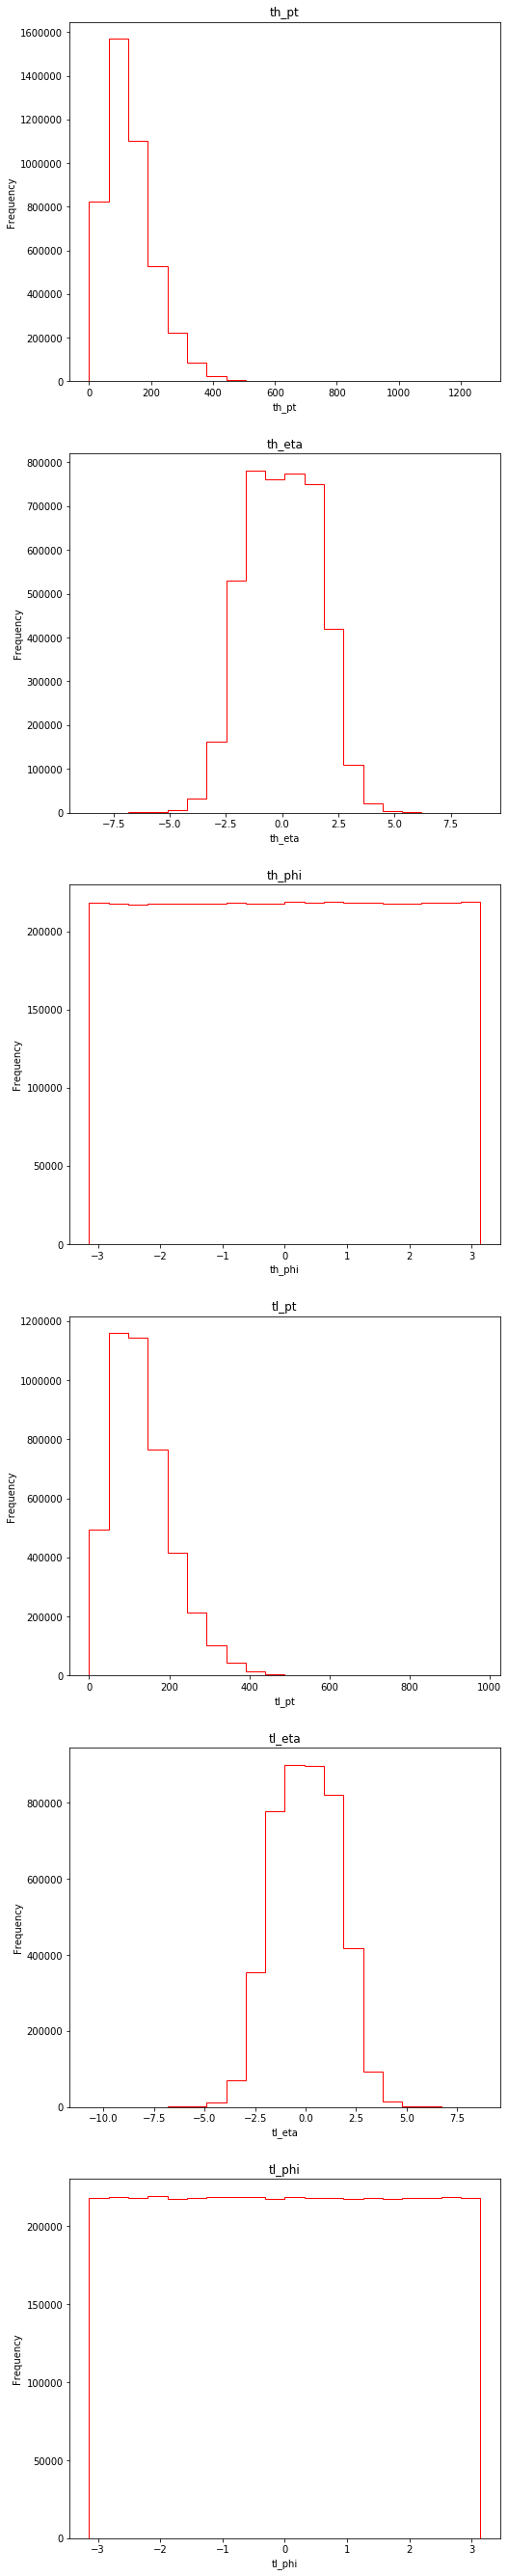

In [5]:
# Original variables

plt.figure(figsize=(8,8*output_length))
for i in range(0, output_length):
    plt.subplot(output_length,1,i+1)
    plt.hist(dataset.get(output_keys[i]), 20, histtype = 'step', color='r')
    plt.xlabel(output_keys[i])
    plt.ylabel('Frequency')
    plt.title(output_keys[i])

In [6]:
# Convert into numpy arrays and mean normalize
crop =  100000

input_arrays = []
output_arrays = [] 
in_std = []
in_mean = []
out_std = []
out_mean = []

# for key in input_keys:
#     exec(key + ' = np.array(dataset.get(key))[0:crop].reshape((1,-1))')
#     exec('{0} = ({0} - np.mean({0}))/np.std({0})'.format(key))
#     exec('input_arrays.append({0})'.format(key))

    
def convert_normalize(keys, std, mean, total):
    for x in keys:
        var = np.array(dataset.get(x))[0:crop].reshape((1,-1))
        sig = np.std(var)*4
        mu = np.mean(var)
        std.append(sig)
        mean.append(mu)
        var = (var - mu)/sig 
        total.append(var)

    
convert_normalize(input_keys, in_std, in_mean, input_arrays)
convert_normalize(output_keys, out_std, out_mean, output_arrays)

out_std = np.array(out_std).reshape((1,-1))
out_mean = np.array(out_mean).reshape((1,-1))
in_std = np.array(in_std).reshape((1,-1))
in_mean = np.array(in_mean).reshape((1,-1))

In [7]:
# Create input and test array
split = int(np.floor(0.8*crop)) # 80/20 split 
shuffle = True
    
total_input = np.stack(input_arrays).reshape((crop, len(input_keys)))
total_output = np.stack(output_arrays).reshape((crop, len(output_keys)))

if shuffle:
    rng_state = np.random.get_state()
    np.random.shuffle(total_input)
    np.random.set_state(rng_state)
    np.random.shuffle(total_output)
    
# size = total_input.shape
# total_input = np.array(np.random.normal(size=total_input.shape))

train_input, test_input = total_input[0:split, :], total_input[split:, :]
train_output, test_output = total_output[0:split,:], total_output[split:,:]

In [8]:
print(train_input.shape, train_output.shape)
print(test_input.shape, test_output.shape)

(80000, 46) (80000, 6)
(20000, 46) (20000, 6)


In [9]:
# Build model

# optimizer = keras.optimizers.RMSprop(learning_rate = 1e-5)
optimizer = keras.optimizers.Adam(learning_rate=1e-4)
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)


def build_model():
    model = keras.Sequential([
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001),
                     input_shape=[len(input_keys)]),
        layers.Dense(128,  activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(len(output_keys),  activation='linear')
    ])
    
    model.compile(loss='mse', optimizer= optimizer, metrics=['mse'])
    return model 

# def build_model():
#     model = keras.Sequential([
#         layers.Dense(6, activation='linear', 
#                      input_shape=[len(input_keys)])])
    
#     model.compile(loss='mse', optimizer= optimizer, metrics=['mse'])
    
#     return model 
    

In [10]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               6016      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 390       
Total params: 31,174
Trainable params: 31,174
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Fit model

Epochs= 128

history = model.fit(train_input, train_output, verbose=1, epochs=Epochs, 
                   validation_split=0.2, shuffle=True, callbacks=[callback],
                   batch_size=512)


Epoch 1/128
125/125 [==============================] - 1s 4ms/step - loss: 0.0734 - mse: 0.0669 - val_loss: 0.0704 - val_mse: 0.0641
Epoch 2/128
125/125 [==============================] - 0s 4ms/step - loss: 0.0697 - mse: 0.0636 - val_loss: 0.0694 - val_mse: 0.0634
Epoch 3/128
125/125 [==============================] - 0s 4ms/step - loss: 0.0689 - mse: 0.0631 - val_loss: 0.0688 - val_mse: 0.0632
Epoch 4/128
125/125 [==============================] - 0s 4ms/step - loss: 0.0683 - mse: 0.0628 - val_loss: 0.0683 - val_mse: 0.0630
Epoch 5/128
125/125 [==============================] - 0s 4ms/step - loss: 0.0678 - mse: 0.0627 - val_loss: 0.0679 - val_mse: 0.0629
Epoch 6/128
125/125 [==============================] - 1s 4ms/step - loss: 0.0674 - mse: 0.0626 - val_loss: 0.0675 - val_mse: 0.0629
Epoch 7/128
125/125 [==============================] - 1s 4ms/step - loss: 0.0670 - mse: 0.0625 - val_loss: 0.0672 - val_mse: 0.0628
Epoch 8/128
125/125 [==============================] - 1s 4ms/step - 

In [12]:
history.history.keys()
model.save(model_name)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: VarianceScaling.h5py/assets


Text(0.5, 1.0, 'MSE loss')

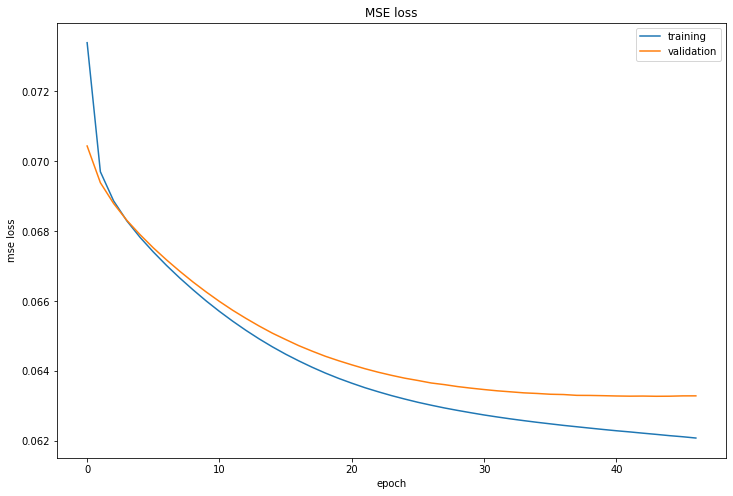

In [13]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('epoch')
plt.ylabel('mse loss')
plt.legend()
plt.title('MSE loss')

In [14]:
predictions = model.predict(test_input)

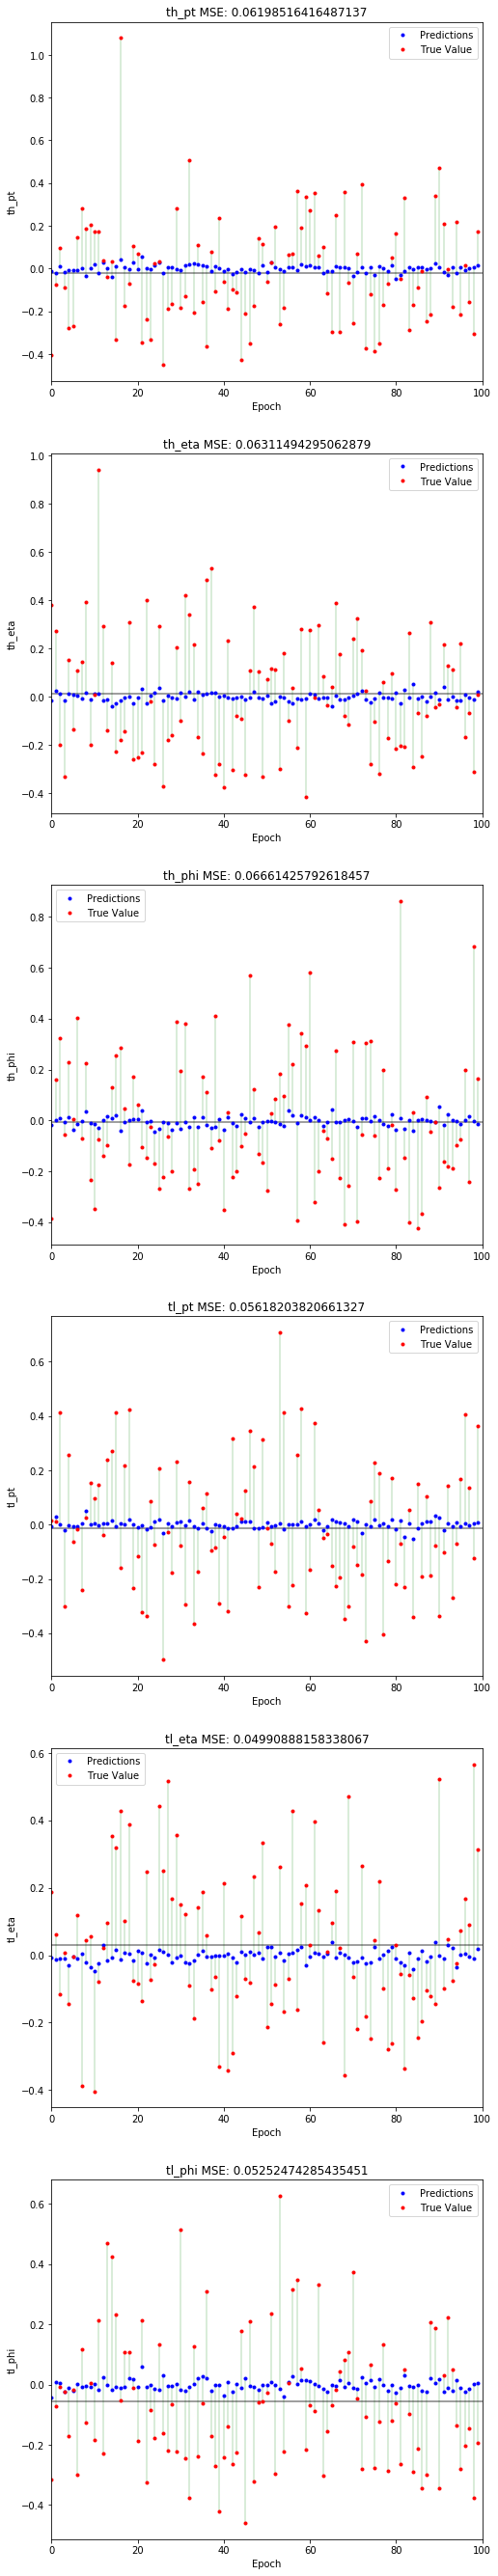

In [15]:
# Training 
crop = 100 

train_small = model.predict(train_input[0:100,:])
output_small = train_output[0:100,:]

def comparison_plot(compare, true):
    plt.figure(figsize=(8,8*output_length))
    for i in range(0,output_length):
        plt.subplot(output_length,1,i+1)
        plt.plot(range(0,crop), compare[:,i], 'bo', markersize=3, label = 'Predictions')
        plt.plot(range(0,crop), true[:,i], 'ro', markersize=3, label = 'True Value')
        ym, yM = plt.ylim()
        for x in range(100):
            plt.vlines(x, color='g', linestyle='-', alpha=0.2, ymin= 
                        min(compare[x,i], true[x,i]), 
                        ymax= max(compare[x,i], true[x,i]))
        plt.hlines(np.mean(true[:,i]), xmin=-20, xmax=crop+20, alpha=0.5)
        MSE = 1/compare[:,i].size*np.sum((compare[:,i]- true[:,i])**2)
        plt.xlabel('Epoch')
        plt.ylabel(output_keys[i])
        plt.xlim(0, crop)
        plt.title(output_keys[i] + " MSE: " + str(MSE))
        plt.legend()

comparison_plot(train_small, output_small)

In [16]:
# Predictions

predictions_small = predictions[0:crop,:]
test_output_small = test_output[0:crop,:]

MSE = 1/predictions.size*np.sum((predictions- test_output)**2)
print("total MSE: " + str(MSE))

for i in range(output_length):
    MSE = 1/predictions[:,i].size*np.sum((predictions[:,i] -test_output[:,i])**2)
    print("{0} MSE : ".format(output_keys[i]), '%.10f'%MSE)

total MSE: 0.06284532247920038
th_pt MSE :  0.0635244401
th_eta MSE :  0.0625669163
th_phi MSE :  0.0624962006
tl_pt MSE :  0.0636216963
tl_eta MSE :  0.0616185344
tl_phi MSE :  0.0632441474


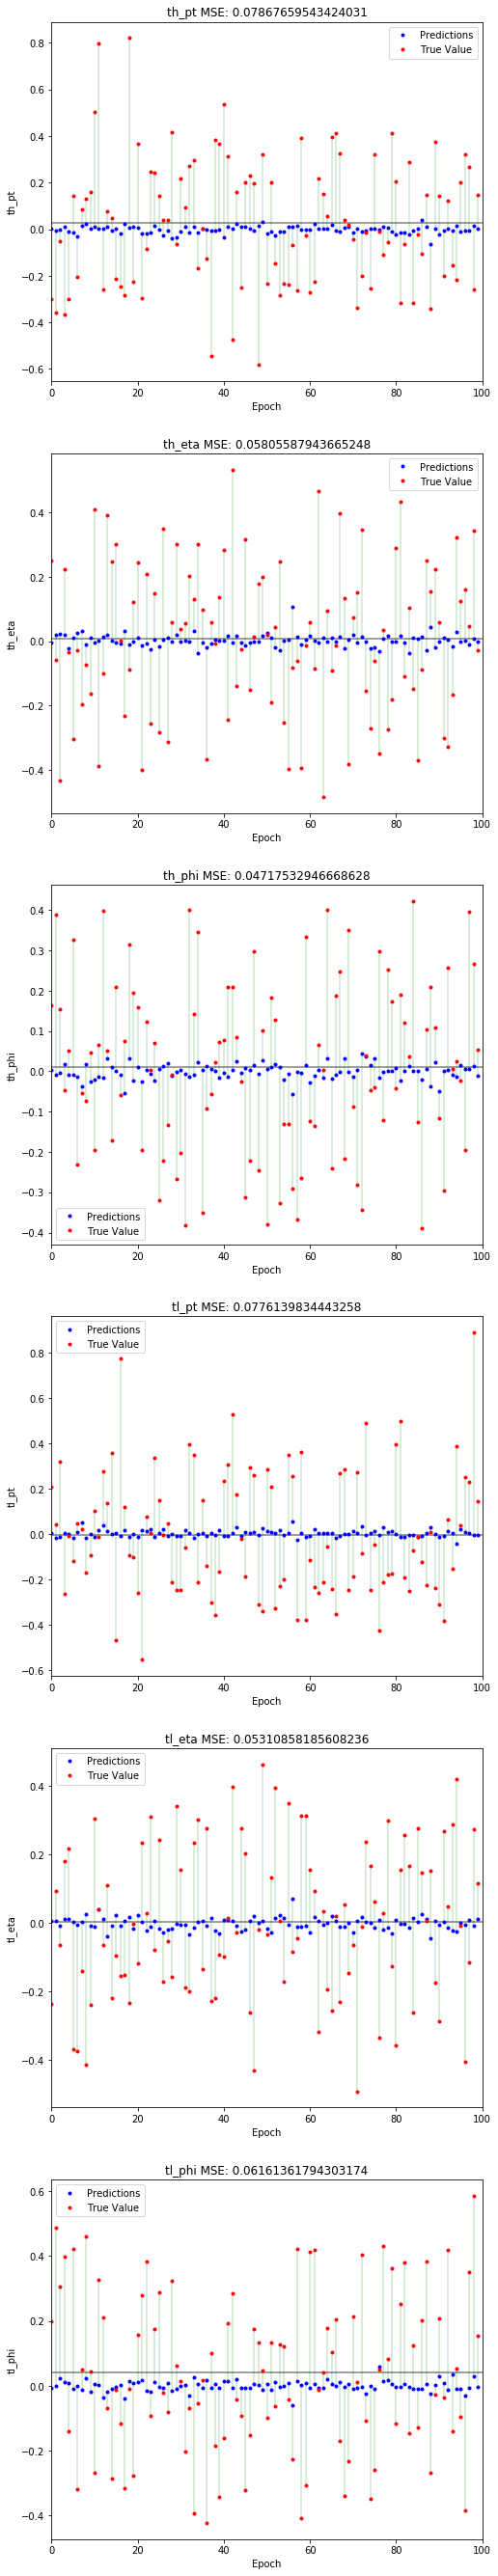

In [17]:
comparison_plot(predictions_small, test_output_small)

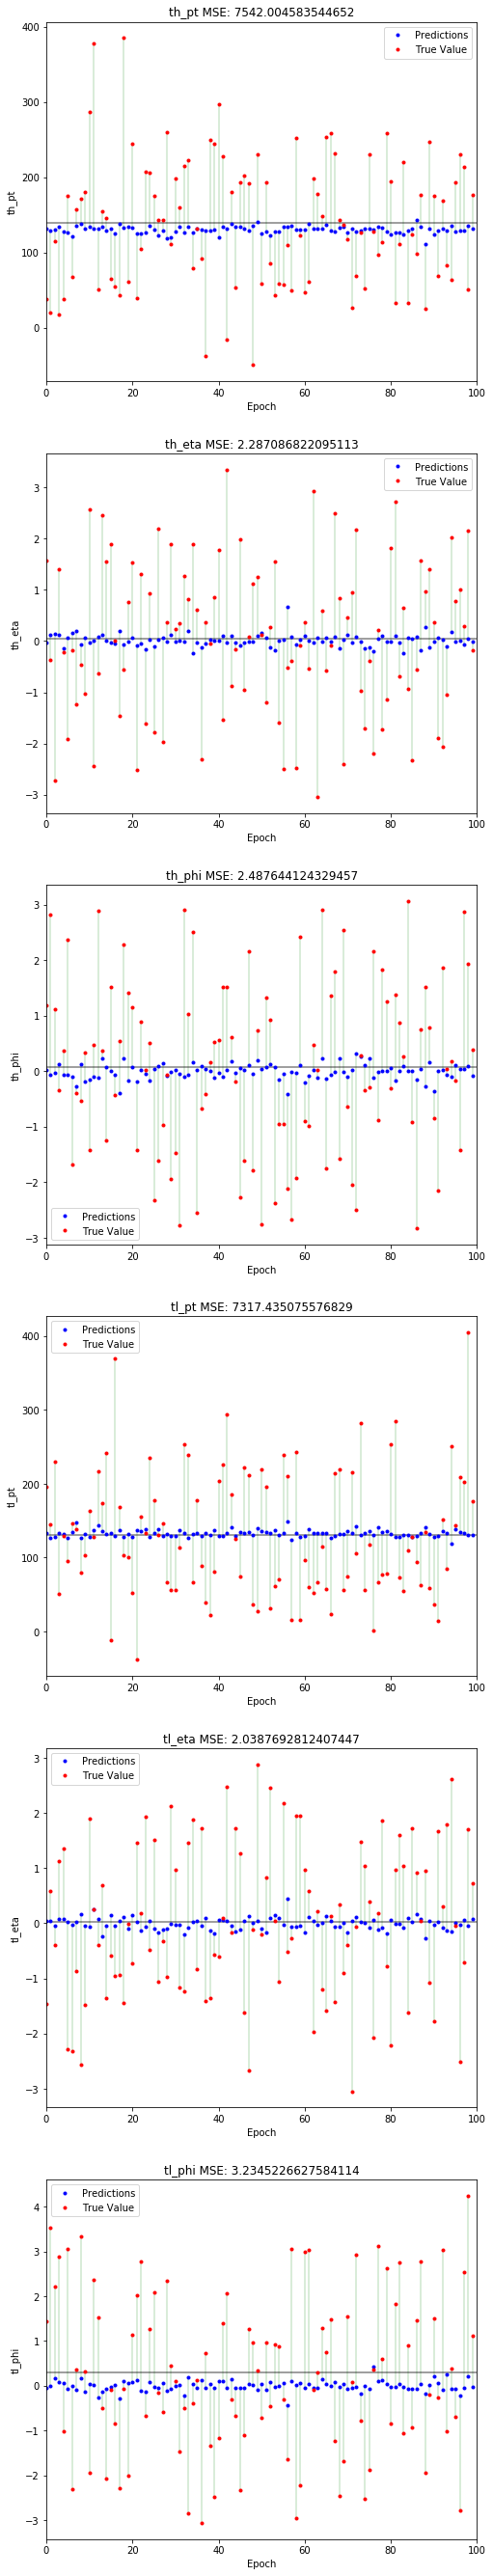

In [18]:
# Back to original units 

scaled_predictions = predictions*out_std + out_mean
scaled_output = test_output*out_std + out_mean

comparison_plot(scaled_predictions[0:crop,:], scaled_output[0:crop,:])


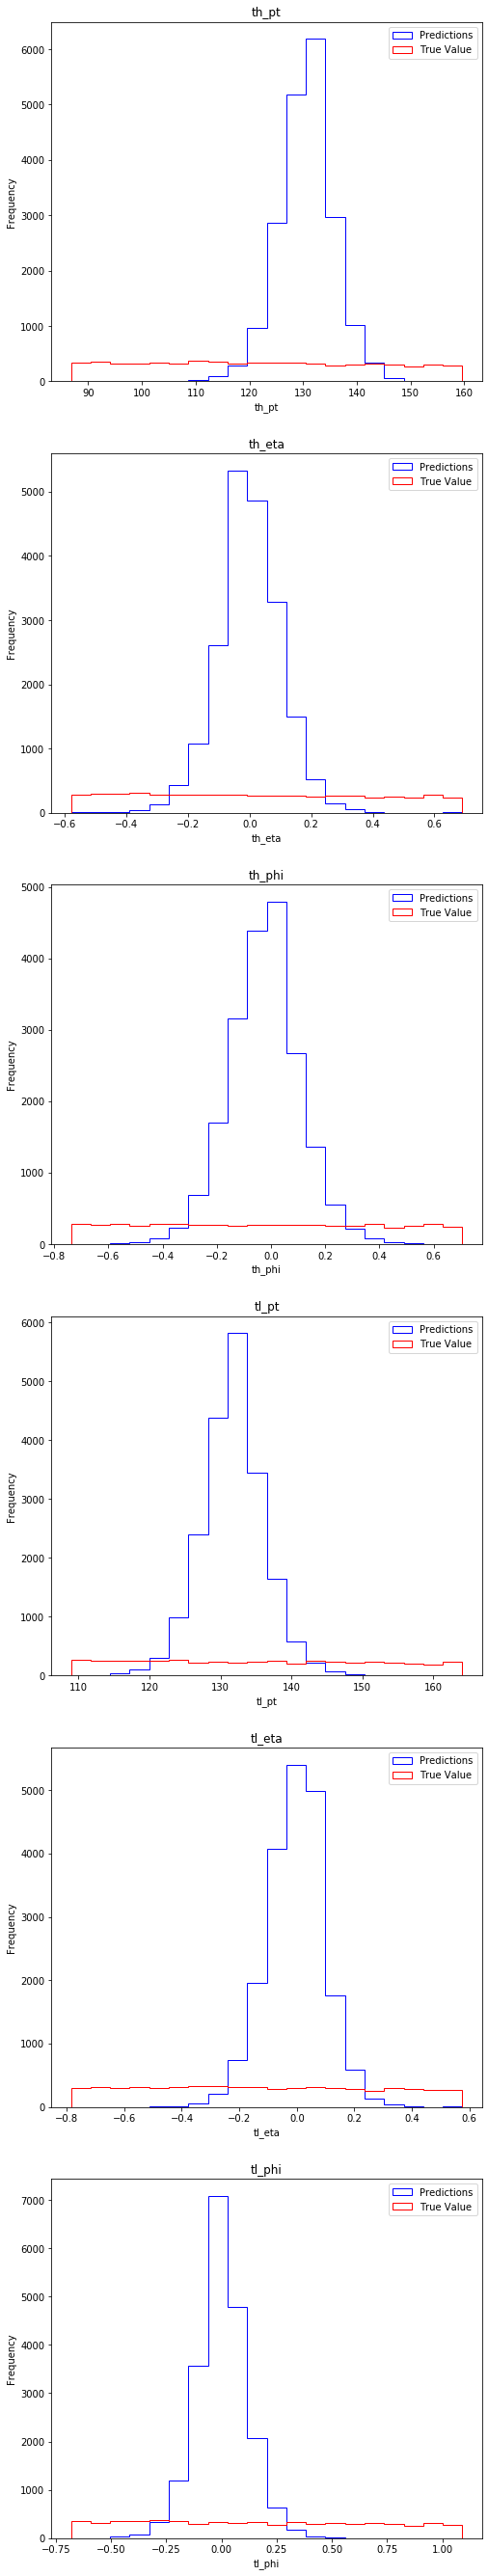

In [19]:
# Histograms 

def histograms(compare, true):
    plt.figure(figsize=(8,8*output_length))
    for i in range(0, output_length):
        plt.subplot(output_length,1,i+1)
        histo, bin_edges = np.histogram(compare[:,i],20)
        plt.hist(compare[:,i], bin_edges, histtype = 'step', color='b', label='Predictions')
        plt.hist(true[:,i], bin_edges, histtype = 'step', color='r', label='True Value')
        plt.xlabel(output_keys[i])
        plt.ylabel('Frequency')
        plt.title(output_keys[i])
        plt.legend()

histograms(scaled_predictions, scaled_output)